In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scvi
import scanpy as sc
import anndata as an
import scanpy.external as sce
import scipy
import scipy.sparse as sp
import time
import sklearn
import torch
from scipy.sparse import csr_matrix

from importlib import reload

# local imports
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3 

In [2]:
print(torch.version.cuda) 

12.0


In [3]:
# Check CUDA availability
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")

    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")

        # Additional information (compute capability, memory)
        gpu_props = torch.cuda.get_device_properties(i)
        print(f"  Compute Capability: {gpu_props.major}.{gpu_props.minor}")
        print(f"  Total Memory: {gpu_props.total_memory / 1024**3:.2f} GB")
else:
    print("CUDA not available. Running on CPU.")

CUDA available: True
Number of GPUs: 1
GPU 0: NVIDIA A100 80GB PCIe MIG 3g.40gb
  Compute Capability: 8.0
  Total Memory: 39.25 GB


In [4]:
def load_annotations(fpath):
    """
    Loads annotations data from a CSV file, processes it, and returns the resulting DataFrame.

    Args:
        fpath (str): The file path to the CSV file containing annotations data.

    Returns:
        pd.DataFrame: The processed DataFrame with 'cell_id' as the index.
    """
    df = pd.read_csv(fpath)
    df['cell_id'] = df['obs_index'].astype(str) + "_" + df["dataset"]
    df = df.drop(columns='dataset')
    df = df.set_index('cell_id')
    return df

In [5]:
"""
DATA
"""
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/merged_anndata/merged_adata.h5ad"
adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
print(adata)

"""
ANNOTATIONS
"""
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/annotation/cell_types.csv"
df = load_annotations(fpath)
df = df[df.index.isin(adata.obs_names)]
print(f"{df.shape=}")

adata.obs = pd.concat([adata.obs, df], ignore_index=False, axis=1)
adata

Memory usage: current 8.69 GB, difference +8.69 GB
AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'
df.shape=(171498, 3)


AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

In [6]:
fpaths = [
    "../resources/PanglaoDB_Augmented_2021.txt",
    "../resources/Tabula_Sapiens.txt",
]

marker_columns = []

for fpath in fpaths:    
    features = ut.load_pathway(fpath)

    # extract columns
    hsc_columns = [x for x in features.columns if "hemato" in x.lower()]
    fib_columns = [x for x in features.columns if "fibroblast" in x.lower()]
    fib_columns = [x for x in fib_columns if not "myofibr" in x.lower()]
    
    columns = list(set(hsc_columns + fib_columns))

    for col in columns:
        gene_list = list(features[features[col].astype(bool)].index)
        print(col, len(gene_list))
        col_name = col.lower().replace("-", " ")
        col_name = col_name.replace(" ", "_") + "_marker"
        marker_columns.append(col_name)
        adata.var[col_name] = adata.var.index.isin(gene_list)
    
adata.var['is_marker'] = adata.var[marker_columns].any(axis=1)
print()
adata

Fibroblasts 232
Hematopoietic Stem Cells 178
Lung-alveolar Fibroblast 100
Tongue-fibroblast 100
Spleen-hematopoietic Stem Cell 100
Eye-fibroblast 100
Pancreas-fibroblast 100
Large Intestine-fibroblast 100
Liver-fibroblast 100
Mammary-fibroblast Of Breast 100
Small Intestine-fibroblast 100
Trachea-fibroblast 100
Lymph Node-hematopoietic Stem Cell 100
Thymus-fibroblast 100
Blood-hematopoietic Stem Cell 100
Heart-fibroblast Of Cardiac Tissue 100
Fat-fibroblast 100
Bone Marrow-hematopoietic Stem Cell 100
Vasculature-fibroblast 100
Bladder-fibroblast 100
Salivary Gland-fibroblast 100
Prostate-fibroblast 100
Lung-fibroblast 100
Uterus-fibroblast 100



AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'fibroblasts_marker', 'hematopoietic_stem_cells_marker', 'lung_alveolar_fibroblast_marker', 'tongue_fibroblast_marker', 'spleen_hematopoietic_stem_cell_marker', 'eye_fibroblast_marker', 'pancreas_fibroblast_marker', 'large_intestine_fibroblast_marker', 'liver_fibroblast_marker', 'mammary_fibroblast_of_breast_marker', 'small_intestine_fibroblast_marker', 'trachea_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'thymus_fibroblast_marker', 'blood_hematopoietic_stem_cell_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'fat_fibroblast_marker', 'bone_marrow_hematopoietic_stem_cell_marker', 'vasculature_fibroblast_marker', 'bladder_fibroblast_marker', 's

# Preprocessing

In [7]:
# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers["log_norm"] = csr_matrix(adata.X.astype('float32').copy())

adata

normalizing counts per cell
    finished (0:00:02)


AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'fibroblasts_marker', 'hematopoietic_stem_cells_marker', 'lung_alveolar_fibroblast_marker', 'tongue_fibroblast_marker', 'spleen_hematopoietic_stem_cell_marker', 'eye_fibroblast_marker', 'pancreas_fibroblast_marker', 'large_intestine_fibroblast_marker', 'liver_fibroblast_marker', 'mammary_fibroblast_of_breast_marker', 'small_intestine_fibroblast_marker', 'trachea_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'thymus_fibroblast_marker', 'blood_hematopoietic_stem_cell_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'fat_fibroblast_marker', 'bone_marrow_hematopoietic_stem_cell_marker', 'vasculature_fibroblast_marker', 'bladder_fibroblast_marker', 's

# Filtering

In [8]:
adata = adata[adata.obs['standard_cell_type'].notna(), :].copy()
adata = adata[adata.obs['standard_cell_type'] != 'NA', :].copy()
adata

AnnData object with n_obs × n_vars = 168264 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'fibroblasts_marker', 'hematopoietic_stem_cells_marker', 'lung_alveolar_fibroblast_marker', 'tongue_fibroblast_marker', 'spleen_hematopoietic_stem_cell_marker', 'eye_fibroblast_marker', 'pancreas_fibroblast_marker', 'large_intestine_fibroblast_marker', 'liver_fibroblast_marker', 'mammary_fibroblast_of_breast_marker', 'small_intestine_fibroblast_marker', 'trachea_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'thymus_fibroblast_marker', 'blood_hematopoietic_stem_cell_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'fat_fibroblast_marker', 'bone_marrow_hematopoietic_stem_cell_marker', 'vasculature_fibroblast_marker', 'bladder_fibroblast_marker', 's

In [9]:
reference_data = [
    'tabula_sapiens',
    'pellin',
    'weng_young2_all',
    'weng_young1_all_t2',
    'weng_young1_all_t1',
    'sc_fib',
]

query_data = [
    'iHSC',
]

# define data sets
rdata = adata[adata.obs['dataset'].isin(reference_data), :].copy()
print(rdata)
qdata = adata[adata.obs['dataset'].isin(query_data), :].copy()
print(qdata)

AnnData object with n_obs × n_vars = 126515 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'fibroblasts_marker', 'hematopoietic_stem_cells_marker', 'lung_alveolar_fibroblast_marker', 'tongue_fibroblast_marker', 'spleen_hematopoietic_stem_cell_marker', 'eye_fibroblast_marker', 'pancreas_fibroblast_marker', 'large_intestine_fibroblast_marker', 'liver_fibroblast_marker', 'mammary_fibroblast_of_breast_marker', 'small_intestine_fibroblast_marker', 'trachea_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'thymus_fibroblast_marker', 'blood_hematopoietic_stem_cell_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'fat_fibroblast_marker', 'bone_marrow_hematopoietic_stem_cell_marker', 'vasculature_fibroblast_marker', 'bladder_fibroblast_marker', 's

In [10]:
rdata.obs['cell_label'] = rdata.obs['standard_cell_type'].apply(lambda x: str(x).strip())
rdata.obs['cell_label'].value_counts()

cell_label
Fib               34289
HSC               16332
LinNeg            13396
T_cell            12091
MPP                7898
B_cell             6638
MEP                6430
EryP               5889
NK                 3954
GMP                3657
CLP                3345
MKP                3147
Mono               2728
CMP                2666
MDP                2091
LMPP                805
PreBNK              554
Dendritic_cell      482
MLP                 123
Name: count, dtype: int64

In [11]:
qdata.obs['cell_label'] = 'Unknown'
qdata.obs['cell_label'].value_counts()

cell_label
Unknown    8379
Name: count, dtype: int64

In [12]:
# break

# Reference Mapping (scANVI)

In [13]:
sc.pp.highly_variable_genes(
    rdata, 
    n_top_genes=2000,
    batch_key="dataset", 
    subset=True,
    layer='log_norm',
)

extracting highly variable genes
    finished (0:00:12)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [14]:
scvi.model.SCVI.setup_anndata(
    rdata, 
    batch_key="dataset",
    layer="counts",
    labels_key='cell_label',
)

In [15]:
torch.cuda.empty_cache()

model = scvi.model.SCVI(
    rdata,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

start_time = time.time()  # Record the start time

model.train(
    max_epochs=10,
    accelerator='gpu',
    train_size=0.8,
    validation_size=0.2,
    plan_kwargs={"weight_decay": 0.1},
)

end_time = time.time()  # Record the end time
total_time = end_time - start_time  # Calculate total execution time

print(f"Training completed in {total_time:.2f} seconds")

# Optional: More detailed timing information
minutes = int(total_time // 60)
seconds = int(total_time % 60)
print(f"Training time: {minutes} minutes {seconds} seconds")

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium'

Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Training completed in 69.43 seconds
Training time: 1 minutes 9 seconds


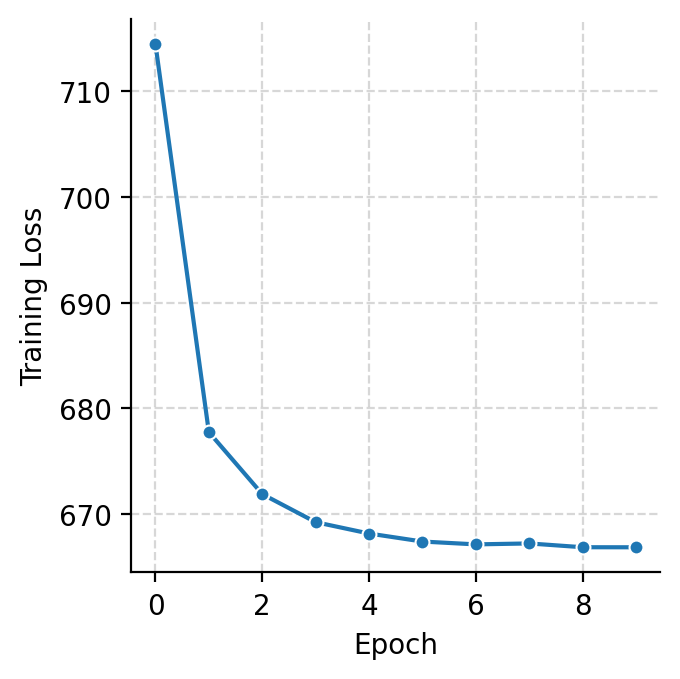

In [16]:
metrics = pd.concat(
    model.history.values(), 
    ignore_index=False,
    axis=1
)

metrics = metrics.reset_index()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 3.5

sns.lineplot(
    data=metrics,
    x='epoch',
    y='train_loss_epoch',
    linewidth=1.5,               
    marker='o',          
    markersize=5
)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks()
plt.yticks()
plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid

sns.despine()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# SCANVI Model

In [17]:
torch.cuda.empty_cache()

# train the scanvi model
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model, 
    unlabeled_category="Unknown",
)

scanvi_model.train(
    max_epochs=10,
    accelerator='gpu',
    train_size=0.8,
    validation_size=0.2,
    plan_kwargs={"weight_decay": 0.1},
)

INFO     Training for 10 epochs.                                                                                   


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-cfb2a8ae-864b-50df-94a5-98983023f29d]
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/pytorch/trainer/

Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


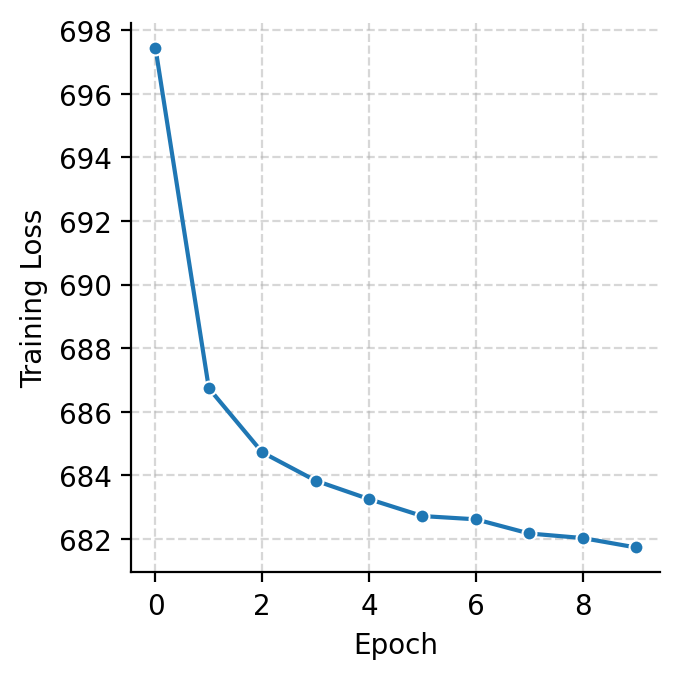

In [18]:
metrics = pd.concat(
    scanvi_model.history.values(), 
    ignore_index=False,
    axis=1
)

metrics = metrics.reset_index()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 3.5

sns.lineplot(
    data=metrics,
    x='epoch',
    y='train_loss_epoch',
    linewidth=1.5,               
    marker='o',          
    markersize=5
)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks()
plt.yticks()
plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid

sns.despine()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Latent Representations (SCVI)

In [ ]:
SCVI_LATENT_KEY = "X_scVI"
SCANVI_LATENT_KEY = "X_scANVI"

rdata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
rdata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation()

sce.pp.bbknn(
    rdata, 
    batch_key='dataset',
    use_rep=SCVI_LATENT_KEY,
)

sc.tl.leiden(
    rdata, 
    key_added='scvi_clusters',
)
sc.tl.umap(rdata)
sc.pl.umap(
    rdata, 
    color=[
        'dataset',
        'standard_cell_type',
        'scvi_clusters',
    ],
    ncols=1,
)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
running Leiden clustering


In [20]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Query mapping (SCVI)

In [ ]:
scvi.model.SCVI.prepare_query_anndata(qdata, model)
scvi_query = scvi.model.SCVI.load_query_data(
    qdata,
    model,
)

In [ ]:
torch.cuda.empty_cache()

scvi_query.train(
    max_epochs=5, 
    plan_kwargs={"weight_decay": 0.0},
)

qdata.obsm[SCVI_LATENT_KEY] = scvi_query.get_latent_representation()
qdata

In [ ]:
SCANVI_PREDICTIONS_KEY = "predictions_scanvi"

pancreas_query.obsm[SCANVI_LATENT_KEY] = scanvi_query.get_latent_representation()
pancreas_query.obs[SCANVI_PREDICTIONS_KEY] = scanvi_query.predict()

In [ ]:
sc.pp.neighbors(qdata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(qdata, key_added='scVI_cluster_iHSC')
sc.tl.umap(qdata)

sc.pl.umap(
    qdata, 
    color=['dataset', 'standard_cell_type'],
    ncols=1,
)

# Integrate

In [ ]:
fdata = an.concat([rdata, qdata], label="batch")
fdata

# filter

In [ ]:
cell_types = [
    'iHSC',
    'Fib',
    'HSC',
]

datasets = [
    'sc_fib',
    'iHSC',
    'weng_young2_all',
]

bdata = fdata[fdata.obs['standard_cell_type'].isin(cell_types), :].copy()
bdata = bdata[bdata.obs['dataset'].isin(datasets), :].copy()
bdata

In [ ]:
sce.pp.bbknn(
    rdata, 
    batch_key='dataset',
    use_rep=SCANVI_LATENT_KEY,
)

sc.tl.umap(
    bdata,
    min_dist=0.25,
)
sc.pl.umap(
    bdata, 
    color=[
        'dataset',
        'standard_cell_type',
        'batch',
    ],
    ncols=1,
)